In [2]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

产生数据

In [3]:
raw_num = 240
col_num = 2000
FILENAME_LABEL_MAP = {
    '100': 0,  # Ball fault - 0.007
    '229': 1,  # Ball fault - 0.014
    '112': 2,  # Ball fault - 0.021
    '204': 3, '241': 3, '253': 3, '265': 3,  # Healthy
    '125': 4,  # IR fault - 0.007
    '138': 5,  # IR fault - 0.014
    '151': 6,  # IR fault - 0.021
    '164': 7,  # OR fault - 0.007 @6
    '177': 8,  # OR fault - 0.014 @6
    '192': 9,  # OR fault - 0.021 @6
}



class Data(object):
    
    def __init__(self):
        self.raw_num = 240
        self.col_num = 2000
        self.data = self.get_data()
        self.label = self.get_label()
        
    def file_list(self):
        return os.listdir('data/')
    
    def get_data(self):
        folder = 'data'
        file_list = [f for f in os.listdir(folder) if f.endswith('.mat')]

        data = None  # 延迟初始化
        for i, fname in enumerate(file_list):
            try:
                file_path = os.path.join(folder, fname)
                file = scio.loadmat(file_path)

                # 查找以 X###_DE_time 格式命名的 key
                key = None
                for k in file.keys():
                    if re.match(r'X\d{3}_DE_time', k):
                        key = k
                        break  # 找到就退出循环

                if key is None:
                    print(f"⚠️ No matching key in {fname}, skipping...")
                    continue

                # 假设你预定义了 raw_num 和 col_num
                sample = file[key][0:480000].reshape(self.raw_num, self.col_num)

                if data is None:
                    data = sample
                else:
                    data = np.vstack((data, sample))

                print(f"✅ Loaded {fname} as {key}")

            except Exception as e:
                print(f"❌ Error loading {fname}: {e}")

        return data
    
    def get_label(self):
        file_list = self.file_list()
        title = np.array([i.replace('.mat', '') for i in file_list])
        label = title[:, np.newaxis]
        label_copy = np.copy(label)
        for _ in range(raw_num-1):
            label = np.hstack((label, label_copy))
        return label.flatten()
    

In [4]:
Data = Data()
data = Data.data
label = Data.label
lb = LabelBinarizer()
y = lb.fit_transform(label)

# Wiener filtering
data_wiener = scipy.signal.wiener(data, mysize=3, noise=None)

# downsampling
index = np.arange(0,2000, 8)
data_samp = data_wiener[:, index]
print(data_samp.shape)
print(y.shape)
y = y[:data_samp.shape[0]]
print(y.shape)  # 应该是 (1200, 6)

✅ Loaded 112.mat as X112_DE_time
✅ Loaded 138.mat as X138_DE_time
✅ Loaded 100.mat as X100_DE_time
✅ Loaded 204.mat as X204_DE_time
✅ Loaded 177.mat as X177_DE_time
✅ Loaded 229.mat as X229_DE_time
✅ Loaded 217.mat as X215_DE_time
✅ Loaded 192.mat as X192_DE_time
✅ Loaded 125.mat as X125_DE_time
✅ Loaded 241.mat as X241_DE_time
(2400, 250)
(2640, 11)
(2400, 11)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_samp, y, test_size=0.3)

In [6]:
def built_model():
    
    input_seq = Input(shape=(250,))
    X = Reshape((250,1))(input_seq)
    
    # encoder1
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_last')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh',
                      data_format='channels_last')(ec1_layer1)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_last')(ec1_layer2)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_last')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh',
                      data_format='channels_last')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_last')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh',
                       data_format='channels_last')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh',
                       data_format='channels_last')(ec2_layer4)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid',
                             data_format='channels_last')(ec2_layer5)
    
    print("ec1_outputs shape:", ec1_outputs.shape)
    print("ec2_outputs shape:", ec2_outputs.shape)
    encoder = multiply([ec1_outputs, ec2_outputs])
    
    dc_layer1 = LSTM(60, return_sequences=True)(encoder)
    dc_layer2 = LSTM(60)(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    num_classes = y.shape[1]
    dc_layer4 = Dense(num_classes, activation='softmax')(dc_layer3)
    
    model = Model(input_seq, dc_layer4)
    
    return model

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [8]:
import time
begain_time = time.time()

In [9]:
model = built_model()
opt = Adam(lr=0.0006)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

ec1_outputs shape: (None, 27, 30)
ec2_outputs shape: (None, 27, 30)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 250, 1)               0         ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 245, 50)              350       ['reshape[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 240, 40)              12040     ['conv1d_2[0][0]']            
                          

In [10]:
history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=400, 
                    verbose=2, validation_data=(X_test, y_test),
                    shuffle=True, initial_epoch=0)

Epoch 1/400
17/17 - 2s - loss: 0.0813 - accuracy: 0.1512 - val_loss: 0.0764 - val_accuracy: 0.1111 - 2s/epoch - 138ms/step
Epoch 2/400
17/17 - 1s - loss: 0.0756 - accuracy: 0.1970 - val_loss: 0.0719 - val_accuracy: 0.2319 - 812ms/epoch - 48ms/step
Epoch 3/400
17/17 - 1s - loss: 0.0723 - accuracy: 0.2661 - val_loss: 0.0669 - val_accuracy: 0.3986 - 807ms/epoch - 47ms/step
Epoch 4/400
17/17 - 1s - loss: 0.0651 - accuracy: 0.3780 - val_loss: 0.0581 - val_accuracy: 0.4542 - 854ms/epoch - 50ms/step
Epoch 5/400
17/17 - 1s - loss: 0.0586 - accuracy: 0.4565 - val_loss: 0.0540 - val_accuracy: 0.5111 - 857ms/epoch - 50ms/step
Epoch 6/400
17/17 - 1s - loss: 0.0527 - accuracy: 0.5381 - val_loss: 0.0473 - val_accuracy: 0.5917 - 925ms/epoch - 54ms/step
Epoch 7/400
17/17 - 1s - loss: 0.0479 - accuracy: 0.5667 - val_loss: 0.0447 - val_accuracy: 0.5931 - 838ms/epoch - 49ms/step
Epoch 8/400
17/17 - 1s - loss: 0.0441 - accuracy: 0.5946 - val_loss: 0.0418 - val_accuracy: 0.6222 - 825ms/epoch - 49ms/step
Ep

In [10]:
#end_time = time.time()
#time = end_time - begain_time
#print('time:', time)

23/23 [==============================] - 0s 7ms/step


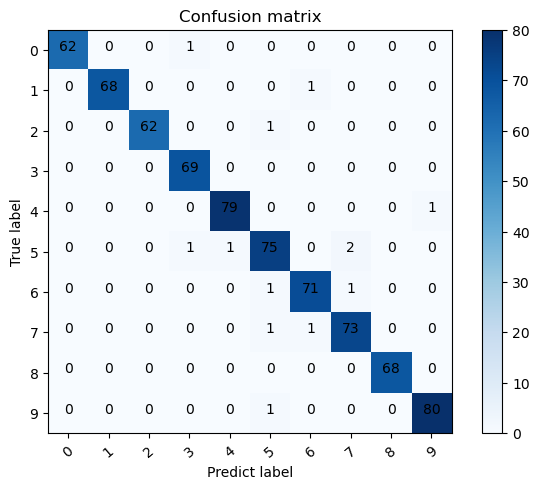

In [11]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))